1. Adding some feature : economic things(ex. interest rates),sentiment score by web scraping (News would be better)  
2. Upgrade models  
3. Add accuracy score, + (add some scores of our models)  

# Stock Price(QQQ) Prediction Project

QQQ is an ETF tracking the NASDAQ-100 Index, bundling major U.S. tech stocks like Apple and Tesla.  
With over 50% weighting in the tech sector, it directly mirrors the growth trajectory of technology industries.  
While highly volatile due to its tech concentration, it has historically delivered strong long-term returns (~15% annual average).   
Short-term performance remains sensitive to interest rate changes and macroeconomic conditions.  

For our price prediction project, we'll focus on analyzing tech trends, earnings reports, and Fed policies as key variables.

## 1. Libraries & APIs

https://www.kaggle.com/code/carlmcbrideellis/lstm-time-series-stock-price-prediction-fail

In [151]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pylab import rcParams
from numpy.random import seed
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [152]:
!pip install yfinance

In [153]:
pip show yfinance

Name: yfinance
Version: 0.2.55
Summary: Download market data from Yahoo! Finance API
Home-page: https://github.com/ranaroussi/yfinance
Author: Ran Aroussi
Author-email: ran@aroussi.com
License: Apache
Location: /usr/local/lib/python3.11/dist-packages
Requires: beautifulsoup4, frozendict, multitasking, numpy, pandas, peewee, platformdirs, pytz, requests
Required-by: 


## 2. Load Data

In this project, the goal is short-term prediction, and to avoid overfitting, it was determined that using 5 years of data is appropriate.  
Therefore, the period was set from 2020 to 2024.

In [154]:
## Stock dataset install
import yfinance as yf

# download using yhfinance
df= yf.download("QQQ", start="2020-01-01", end="2024-12-31", auto_adjust=False)

[*********************100%***********************]  1 of 1 completed


In [155]:
# reset_index to add the data column
df = df.reset_index()
df.head()

Price,Date,Adj Close,Close,High,Low,Open,Volume
Ticker,,QQQ,QQQ,QQQ,QQQ,QQQ,QQQ
0,2020-01-02,209.325897,216.160004,216.160004,213.979996,214.399994,30969400
1,2020-01-03,207.408478,214.179993,215.470001,213.279999,213.300003,27518900
2,2020-01-06,208.744858,215.559998,215.589996,212.240005,212.500000,21655300
3,2020-01-07,208.715805,215.529999,216.139999,214.850006,215.639999,22139300
4,2020-01-08,210.284592,217.149994,218.139999,215.160004,215.500000,26397300


In [156]:
# Rename columns
df.columns = ['date', 'adj close', 'close', 'high', 'low', 'open', 'volume']
df.head()

,date,adj close,close,high,low,open,volume
0,2020-01-02,209.325897,216.160004,216.160004,213.979996,214.399994,30969400
1,2020-01-03,207.408478,214.179993,215.470001,213.279999,213.300003,27518900
2,2020-01-06,208.744858,215.559998,215.589996,212.240005,212.500000,21655300
3,2020-01-07,208.715805,215.529999,216.139999,214.850006,215.639999,22139300
4,2020-01-08,210.284592,217.149994,218.139999,215.160004,215.500000,26397300


In [157]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1257 entries, 0 to 1256
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       1257 non-null   datetime64[ns]
 1   adj close  1257 non-null   float64       
 2   close      1257 non-null   float64       
 3   high       1257 non-null   float64       
 4   low        1257 non-null   float64       
 5   open       1257 non-null   float64       
 6   volume     1257 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 68.9 KB


In [158]:
print("Null Values:", df.isnull().values.sum())
print("NA Values:", df.isna().values.any())

Null Values: 0
NA Values: False


## 3. EDA(Exploratory Data Analysis)

### 3.1. Duration of Dataset

In [159]:
print("Starting date: ", df.iat[0, 0])
print("Ending date: ", df.iat[-1, 0])
print("Total number of days: ",df.shape[0])
print("Total number of fields: ",df.shape[1])

Starting date:  2020-01-02 00:00:00
Ending date:  2024-12-30 00:00:00
Total number of days:  1257
Total number of fields:  7


### 3.2. Stock Price Trends

First, it is necessary to visualize the stock price trends from 2020 to 2024 to intuitively understand the data.  
This will help quickly identify trends, volatility, outliers, and specific patterns, providing valuable insights for model building.

In [160]:
import matplotlib.pyplot as plt

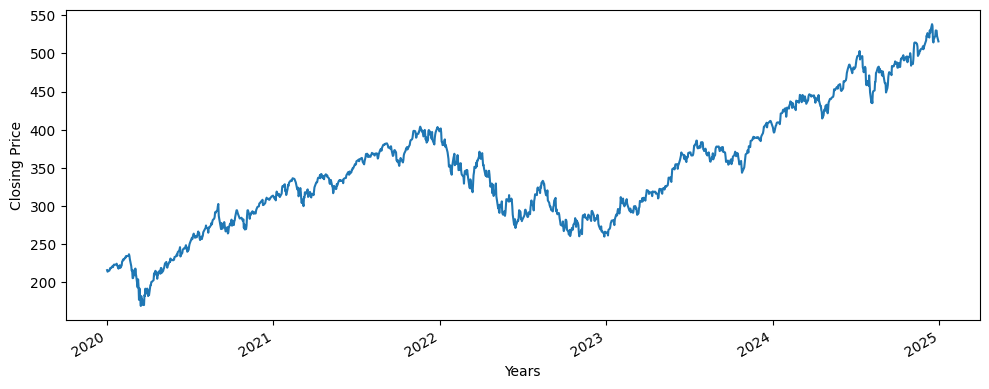

In [161]:
# Visualize 5 years of stock price data
fig, ax = plt.subplots(figsize=(10, 4))

ax.plot(df['date'], df['close'])
ax.set_xlabel('Years')
ax.set_ylabel('Closing Price')
fig.autofmt_xdate()

plt.tight_layout()
plt.show()

✅ Through the above graph, we can understand the overall trend over the past 5 years. Overall, there is an upward trend, but there are sharp declines in the early part of 2020 and between 2022 and 2023. To examine this in more detail, let's look at the graphs for each year.

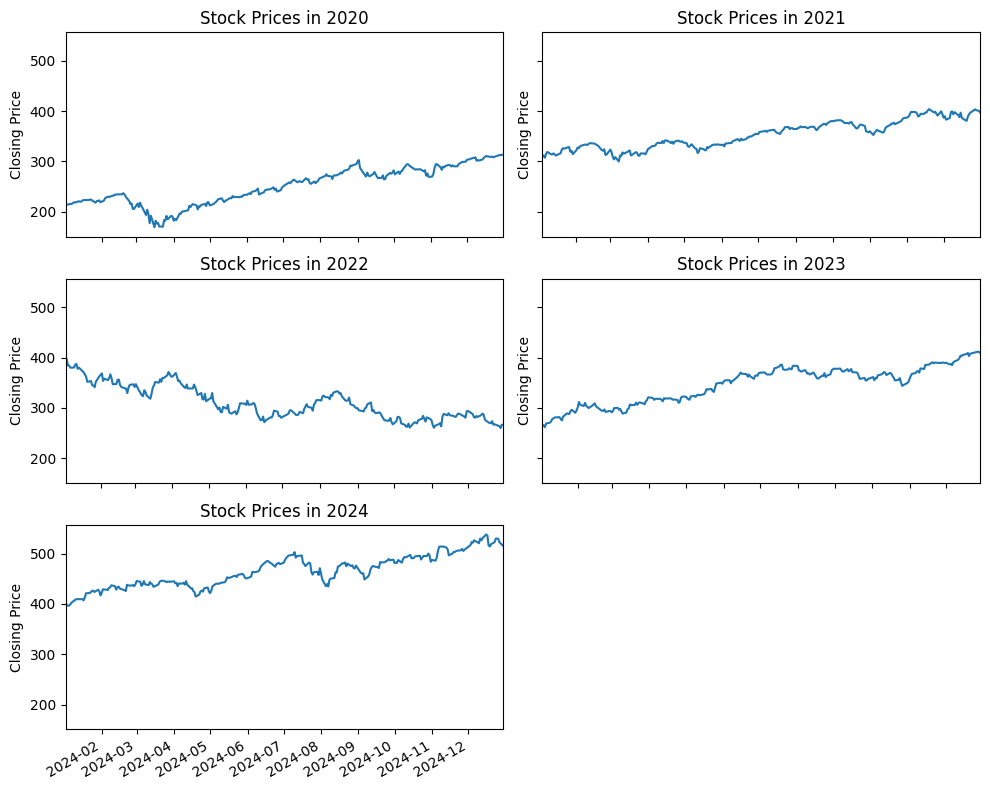

In [162]:
# Visualizing 5 years of data using a 3x2 subplot layout
fig, axes = plt.subplots(3, 2, figsize=(10, 8), sharex=False, sharey=True)

years = [2020, 2021, 2022, 2023, 2024]

# Plot each year's data
for i, year in enumerate(years):
    row, col = i // 2, i % 2
    df_year = df[df['date'].dt.year == year]

    # Plot only if data is available
    if not df_year.empty:
        axes[row, col].plot(df_year['date'], df_year['close'])
        axes[row, col].set_title(f"Stock Prices in {year}")
        axes[row, col].set_ylabel("Closing Price")

        # Set X-axis limits from the start to the end of the year
        axes[row, col].set_xlim(df_year['date'].min(), df_year['date'].max())

# Remove empty subplots if any
for i in range(len(years), 6):
    fig.delaxes(axes[i // 2, i % 2])

# Automatically adjust X-axis date format
fig.autofmt_xdate()

# Adjust layout and display the plots
plt.tight_layout()
plt.show()


### ✅ Key Events Impacting the Stock Market in 2020, 2022

- **2020.02**  
**COVID-19 pandemic** broke out, increasing global uncertainty and causing a sharp decline in stock prices.
Later, a rebound occurred as government stimulus measures and central bank interest rate cuts helped the stock market recover.

- **2022.02**   
**Russia vs. Ukraine war** began.
Energy and commodity prices soared, leading to worsening global economic inflation.
Increased uncertainty caused stock prices to drop.

- **2022.03**   
**Fed's interest rate hike (0.25%) began**, aimed at controlling inflation, but it negatively impacted the stock market.

- **2022.06, 07, 09**   
**Fed's interest rate hikes (each 0.75%)** were implemented.
The June and July rate hikes especially caused significant market volatility, further deepening the downward trend in the stock market.

### 3.3. Seasonality, Yearly Trend

To understand the seasonality, trends, and patterns in the stock market over the past five years, we calculate the monthly and yearly average closing prices.

**Seasonality Check**  
The stock market can exhibit recurring patterns at specific times of the year. For example, phenomena like the Year-end Rally or low trading volumes during the summer are commonly observed in the market. By calculating the average closing price per month, we can identify which months tend to show bullish or bearish trends.

**Yearly Trend Analysis**  
To understand the long-term market trends, we conduct a yearly average closing price analysis. This allows us to assess the overall market flow in each year and identify periods of significant volatility.

In [163]:
# Extract the month and year from the 'Date' column
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year


# Calculate the mean close price per month
monthly_mean = df.groupby(['month'])['close'].mean().reset_index()

# Calculate the mean close price per year
yearly_mean = df.groupby(['year'])['close'].mean().reset_index()

print("\n<Monthly Mean Close Price> \n", monthly_mean)
print("\n<Yearly Mean Close Price> \n", yearly_mean)


<Monthly Mean Close Price> 
     month       close
0       1  320.169998
1       2  329.128750
2       3  316.779909
3       4  327.599127
4       5  328.470763
5       6  338.271619
6       7  355.802095
7       8  360.470450
8       9  354.570971
9      10  356.928442
10     11  369.487185
11     12  378.381808

<Yearly Mean Close Price> 
    year       close
0  2020  250.558380
1  2021  353.040874
2  2022  310.738645
3  2023  345.773800
4  2024  464.681512


#### 3.3.1 Seasonality Check

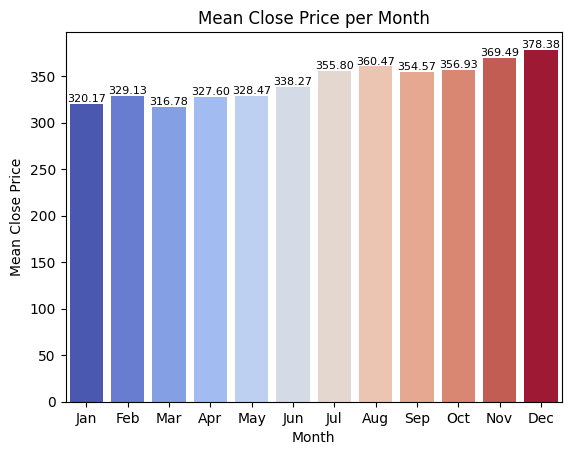

In [164]:
# Plot the mean close price per month using a Seaborn bar chart
ax = sns.barplot(data=monthly_mean, x='month', y='close', hue='month', palette='coolwarm', legend=False)

plt.title('Mean Close Price per Month')
plt.xlabel('Month')
plt.ylabel('Mean Close Price')

# X-axis ticks for each month
plt.xticks(range(0, 12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                                  'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

# Adding the value labels on top of bars
for bars in ax.containers:
    ax.bar_label(bars, fontsize=8, fmt='%.2f')

plt.show()

### 📈 **Monthly Seasonality (Strong Bullish/Bearish Periods)**

**Bullish in the Second Half** (July to December)  
From June (338) to December (378), a +11.8% increase.  
Especially a sharp rise from November (369) to December (378) → aligns with the "Year-end Rally" phenomenon.

**Volatility in the First Half** (January to March)  
From January (320) to March (316), a -1.3% decrease → no sign of the "January Effect" (traditionally a bullish January).

**Summer Stagnation** (July to September)  
From July (355) to September (354), a slight decline of -0.3%.

#### 3.3.2 Yearly Trend Analysis

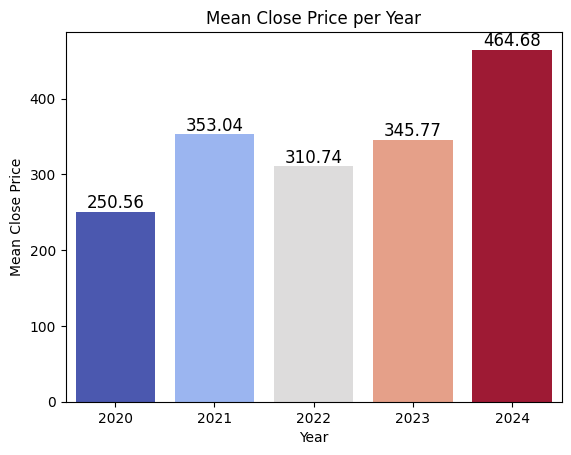

In [165]:
lst_year= yearly_mean['year'].tolist()

# Plot the mean close price per month using a Seaborn bar chart
ax = sns.barplot(data=yearly_mean, x='year', y='close', palette='coolwarm', hue = 'year', legend = False)

plt.title('Mean Close Price per Year')
plt.xlabel('Year')
plt.ylabel('Mean Close Price')

plt.xticks(range(0, len(lst_year)), labels=lst_year)

for bars in ax.containers:
     ax.bar_label(bars, fontsize=12, fmt='%.2f')

plt.show()

### 📊 **Annual Trend (5-Year Long-Term Performance)**

Annual Average Return from 2020 to 2024: +16.7% (250 → 464)

**2021:** +40.9% (250 → 353) → Tech sector boom

**2022:** -12.0% (353 → 310) → Impact of interest rate hikes

**2024:** +34.4% (345 → 464) → AI rally driving growth

## 4. Feature Engineering (Technical Indicators)

- Moving Averages (MA): Smooths stock price movements to identify short-term and long-term trends (e.g., 5-day, 20-day, 50-day, 200-day).
- Relative Strength Index (RSI): Measures whether a stock is overbought or oversold, reflecting price momentum.
- MACD (Moving Average Convergence Divergence): Identifies trend changes and momentum using two moving averages.
- Bollinger Bands: Measures price volatility and deviation from the average price.
- Volume Volatility: Analyzes the relationship between price and trading volume to predict market movements.
- Open-Close Difference: Indicates daily price volatility and potential trend strength.
- High-Low Difference: Represents intraday volatility, with larger differences signaling higher fluctuations.
- High-Open Difference (High_Open_Diff): Measures how much the high price (high) has increased compared to the opening price (open) during the day.
- Low-Close Difference (Low_Close_Diff): Measures how much the closing price (close) has recovered compared to the low price (low) during the day.

In [166]:
# 1. Moving Average (MA)
df['MA_5'] = df['close'].rolling(window=5).mean()  # 5-day moving average
df['MA_20'] = df['close'].rolling(window=20).mean()  # 20-day moving average
df['MA_50'] = df['close'].rolling(window=50).mean()  # 50-day moving average

# 2. Relative Strength Index (RSI)
delta = df['close'].diff()
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()
rs = avg_gain / avg_loss
df['RSI'] = 100 - (100 / (1 + rs))

# 3. MACD (Moving Average Convergence Divergence)
df['EMA_12'] = df['close'].ewm(span=12, adjust=False).mean()  # 12-day exponential moving average
df['EMA_26'] = df['close'].ewm(span=26, adjust=False).mean()  # 26-day exponential moving average
df['MACD'] = df['EMA_12'] - df['EMA_26']

# 4. Bollinger Bands
df['Bollinger_Upper'] = df['MA_20'] + 2 * df['close'].rolling(window=20).std()
df['Bollinger_Lower'] = df['MA_20'] - 2 * df['close'].rolling(window=20).std()

# 5. Volume
df['Volume_MA_20'] = df['volume'].rolling(window=20).mean()  # 20-day moving average of volume

# 6. Open-Close, High-Low Difference
df['Open_Close_Diff'] = df['open'] - df['close']
df['High_Low_Diff'] = df['high'] - df['low']

# 8. High-Open Difference, Low-Close Difference
df['High_Open_Diff'] = df['high'] - df['open']
df['Low_Close_Diff'] = df['low'] - df['close']

In [167]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1257 entries, 0 to 1256
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date             1257 non-null   datetime64[ns]
 1   adj close        1257 non-null   float64       
 2   close            1257 non-null   float64       
 3   high             1257 non-null   float64       
 4   low              1257 non-null   float64       
 5   open             1257 non-null   float64       
 6   volume           1257 non-null   int64         
 7   month            1257 non-null   int32         
 8   year             1257 non-null   int32         
 9   MA_5             1253 non-null   float64       
 10  MA_20            1238 non-null   float64       
 11  MA_50            1208 non-null   float64       
 12  RSI              1244 non-null   float64       
 13  EMA_12           1257 non-null   float64       
 14  EMA_26           1257 non-null   float64

## 5. Modeling (1)

We conducted a simple modeling process using the technical indicators added through feature engineering.  
We evaluated the models using a baseline model, XGBoost, and LSTM, and compared their performance based on Mean Absolute Error (MAE) values.

### 5.1. Baseline Model : Linear Regression (5 Days Moving Average)

In [168]:
# Calculate 5-day Moving Average (MA_5)
df['MA_5'] = df['close'].rolling(window=5).mean()

# Use the 5-day Moving Average as the baseline model's prediction
# Since we want to predict the next day's closing price, shift the MA_5 by 1 day
df['predicted_close_ma'] = df['MA_5'].shift(1)

# Remove the NaN values caused by the shift
df = df.dropna(subset=['predicted_close_ma'])

# Define the features and target for the MA model
X_baseline = df[['MA_5']]  # Using the MA_5 as the feature
y_baseline = df['close']   # Actual close prices are the target

# Train-test split
X_train_baseline, X_test_baseline, y_train_baseline, y_test_baseline = train_test_split(X_baseline, y_baseline, test_size=0.2, random_state=42)

# Train a model (Linear Regression)
baseline_model = LinearRegression()
baseline_model.fit(X_train_baseline, y_train_baseline)

# Prediction
y_pred_baseline = baseline_model.predict(X_test_baseline)

# Evaluate the baseline model
mae_ma5 = mean_absolute_error(y_test_baseline, y_pred_baseline)
print(f"Baseline MAE (MA_5): {mae_ma5}")

Baseline MAE (MA_5): 4.033622680676468


### 5.2. XGBoost

<ipython-input-169-4ab78eedbecf>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.ffill(inplace=True)


XGBoost MAE: 2.81959649196184


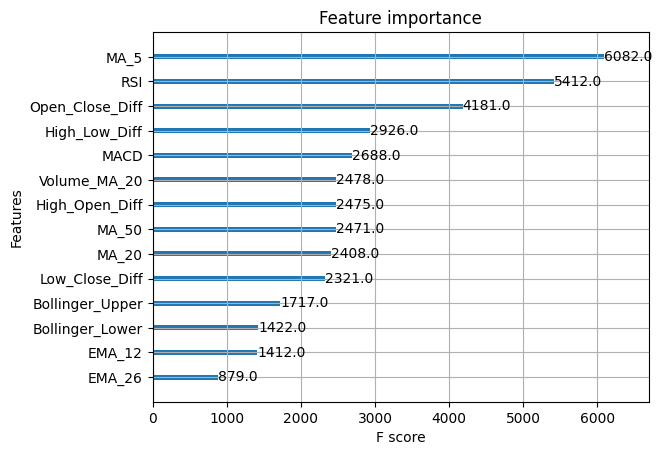

In [169]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import xgboost as xgb

# Fill missing values
df.ffill(inplace=True)

# Define the features and target variable
# Use the technical indicators (excluding date and adj close)
features = ['MA_5', 'MA_20', 'MA_50', 'RSI', 'EMA_12', 'EMA_26', 'MACD', 'Bollinger_Upper', 'Bollinger_Lower',
            'Volume_MA_20', 'Open_Close_Diff', 'High_Low_Diff', 'High_Open_Diff', 'Low_Close_Diff']
target = 'close'

X = df[features]
y = df[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train XGBoost model (with tuned hyperparameters)
model = xgb.XGBRegressor(
    n_estimators=1000, #EX
    learning_rate=0.01, #EX
    max_depth=6, #EX
    subsample=0.8,#EX
    colsample_bytree=0.8, #EX
    random_state=42
)

model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
print(f"XGBoost MAE: {mae}")
mae_xgboost = mae

# plot feature importance
xgb.plot_importance(model, importance_type='weight')
plt.show()

### 5.3. LSTM

In [170]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 103ms/step - loss: 0.1042 - val_loss: 0.0037
Epoch 2/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - loss: 0.0058 - val_loss: 0.0014
Epoch 3/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 0.0041 - val_loss: 6.9965e-04
Epoch 4/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 0.0032 - val_loss: 0.0011
Epoch 5/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0035 - val_loss: 6.6331e-04
Epoch 6/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - loss: 0.0033 - val_loss: 9.2198e-04
Epoch 7/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 0.0034 - val_loss: 7.6274e-04
Epoch 8/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 0.0027 - val_loss: 6.6461e-04
Epoch 9/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 0.0025 - val_loss: 0.0013
Epoch 10/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 0.0032 - val_loss: 0.0011
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step


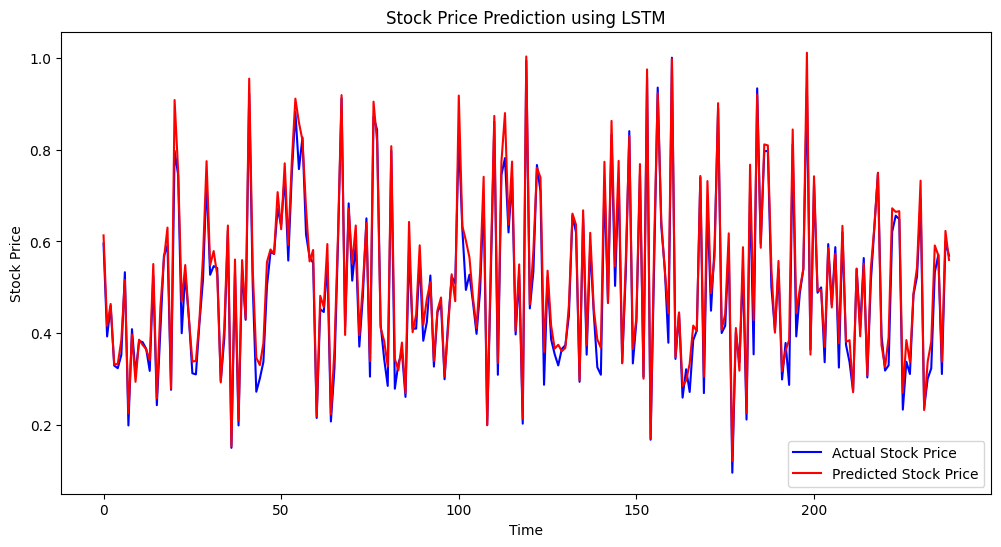

LSTM MAE: 0.024623792499625267


In [171]:
# Feature Scaling (Scaling values between 0 and 1 for LSTM input)
scaler = MinMaxScaler(feature_range=(0, 1))

# Normalize only the 'close' (since we will use it as the target)
scaled_data = scaler.fit_transform(df['close'].values.reshape(-1, 1))

# Create time-series dataset
def create_dataset(data, window_size=60):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i, 0])  # X contains the data for the window size
        y.append(data[i, 0])  # y is the next day's closing price
    return np.array(X), np.array(y)

window_size = 60  # Use a window of 60 days to predict the next day
X, y = create_dataset(scaled_data, window_size)

# Reshape data (LSTM input requires 3D array)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))  # (samples, timesteps, features)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build LSTM model
model = Sequential()

# LSTM layer
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))  # Dropout to prevent overfitting

# LSTM layer
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

# Fully connected layer
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Make predictions
y_pred = model.predict(X_test)

# Visualize the results
plt.figure(figsize=(12, 6))
plt.plot(y_test, color='blue', label='Actual Stock Price')
plt.plot(y_pred, color='red', label='Predicted Stock Price')
plt.title('Stock Price Prediction using LSTM')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

# Evaluate the model (Calculate MAE)
mae_lstm = mean_absolute_error(y_test, y_pred)
print(f"LSTM MAE: {mae_lstm}")

### 5.4. Modeling(1) Results

In [172]:
mae_results = {
    'Model': ['Baseline(MA_5)', 'XGBoost', 'LSTM'],
    'MAE': [mae_ma5, mae_xgboost, mae_lstm]
}

mae_df = pd.DataFrame(mae_results)

mae_df = mae_df.sort_values(by='MAE')

print(mae_df)

            Model       MAE
2            LSTM  0.024624
1         XGBoost  2.819596
0  Baseline(MA_5)  4.033623


The LSTM model appears to have the best performance, as it recorded the lowest MAE. However, as seen in the graph, there is a possibility of overfitting. Therefore, we proceed by adding additional indicators for a more detailed analysis.

## 6. Feature Engineering - Economical Indicators

In [173]:
# Set data range
start_date = "2020-01-01"
end_date = "2024-12-31"

### 6.1. Interest Rate (Federal Funds Rate, daily)

In [174]:
!pip install pandas_datareader

In [175]:
import pandas_datareader.data as web

In [176]:
# Pull Federal Funds Rate (interest rate) from FRED
interest = web.DataReader('FEDFUNDS', 'fred', start=start_date, end=end_date)

# Rename and reset index
interest.rename(columns={'FEDFUNDS': 'interest_rate'}, inplace=True)
interest.reset_index(inplace=True)

Convert Monthly/Weekly Rate to Daily by Forward Fill

In [177]:
# Fill daily rows from monthly/weekly by forward filling
interest = interest.set_index('DATE').resample('D').ffill().reset_index()
interest.rename(columns={'DATE': 'date'}, inplace=True)


Merge with our QQQ dataset

In [178]:
df = pd.merge(df, interest, on='date', how='left')

In [179]:
# Check first few rows with the new interest_rate column
df[['date', 'close', 'interest_rate']].head(10)

,date,close,interest_rate
0,2020-01-09,218.990005,1.55
1,2020-01-10,218.429993,1.55
2,2020-01-13,220.949997,1.55
3,2020-01-14,220.080002,1.55
4,2020-01-15,220.169998,1.55
5,2020-01-16,222.279999,1.55
6,2020-01-17,223.380005,1.55
7,2020-01-21,223.279999,1.55
8,2020-01-22,223.869995,1.55
9,2020-01-23,224.589996,1.55


In [180]:
df['interest_rate'].isnull().sum()

np.int64(20)

In [181]:
df['interest_rate'] = df['interest_rate'].ffill()

### 6.2. Gold Price (daily)

In [182]:
gold = yf.download("GC=F", start=start_date, end=end_date)[['Close']]
# Flatten MultiIndex column names
gold.columns = gold.columns.get_level_values(0)
gold = gold.reset_index()  # 'Date' becomes a regular column
gold.rename(columns={'Close': 'gold_price', 'Date': 'date'}, inplace=True)  # Rename 'Date' to 'date'


[*********************100%***********************]  1 of 1 completed


In [183]:
print("df index:", df.index.names)
print("gold index:", gold.index.names)
print(gold.columns)


df index: [None]
gold index: [None]
Index(['date', 'gold_price'], dtype='object', name='Price')


In [184]:
df = pd.merge(df, gold[['date', 'gold_price']], on='date', how='left')
df['gold_price'] = df['gold_price'].ffill()

In [185]:
print(df[['date', 'close', 'gold_price']].head())
print(df['gold_price'].isnull().sum())

        date       close   gold_price
0 2020-01-09  218.990005  1551.699951
1 2020-01-10  218.429993  1557.500000
2 2020-01-13  220.949997  1548.400024
3 2020-01-14  220.080002  1542.400024
4 2020-01-15  220.169998  1552.099976
0


### 6.3.CPI (Inflation Rate)

In [186]:
# 1. Get CPI from FRED
cpi = web.DataReader("CPIAUCSL", "fred", start=start_date, end=end_date)

# 2. Prepare & forward-fill daily
cpi.rename(columns={"CPIAUCSL": "cpi"}, inplace=True)
cpi.reset_index(inplace=True)
cpi = cpi.set_index('DATE').resample('D').ffill().reset_index()
cpi.rename(columns={'DATE': 'date'}, inplace=True)


In [187]:
df = pd.merge(df, cpi, on='date', how='left')
df['cpi'] = df['cpi'].ffill()

In [188]:
print(df[['date', 'close', 'interest_rate', 'gold_price', 'cpi']].head())
print(df[['interest_rate', 'gold_price', 'cpi']].isnull().sum())

        date       close  interest_rate   gold_price      cpi
0 2020-01-09  218.990005           1.55  1551.699951  259.127
1 2020-01-10  218.429993           1.55  1557.500000  259.127
2 2020-01-13  220.949997           1.55  1548.400024  259.127
3 2020-01-14  220.080002           1.55  1542.400024  259.127
4 2020-01-15  220.169998           1.55  1552.099976  259.127
interest_rate    0
gold_price       0
cpi              0
dtype: int64


In [189]:
# View a few rows
print(df[['date', 'close', 'interest_rate', 'gold_price', 'cpi']].head())

# Check for any missing values
print(df[['interest_rate', 'gold_price', 'cpi']].isnull().sum())


        date       close  interest_rate   gold_price      cpi
0 2020-01-09  218.990005           1.55  1551.699951  259.127
1 2020-01-10  218.429993           1.55  1557.500000  259.127
2 2020-01-13  220.949997           1.55  1548.400024  259.127
3 2020-01-14  220.080002           1.55  1542.400024  259.127
4 2020-01-15  220.169998           1.55  1552.099976  259.127
interest_rate    0
gold_price       0
cpi              0
dtype: int64


In [190]:

df.to_csv("enhanced_stock_data.csv", index=False, encoding='utf-8')


## 7. Modeling (2)

### 7.1. Baseline Model with Technical Indicators Only

We created a baseline model using the 5-day moving average. To improve it, we added technical indicators to see if we could achieve more accurate predictions.

In [191]:
features_baseline = ['MA_5', 'RSI', 'MACD', 'Volume_MA_20', 'Open_Close_Diff', 'High_Low_Diff']


In [192]:
# Drop NA rows and select features
df_base = df.dropna()
X_base = df_base[features_baseline]
y_base = df_base['close']

# Split train/test
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_base, y_base, test_size=0.2, shuffle=False)

# Train Linear Regression
lr_model_b = LinearRegression()
lr_model_b.fit(X_train_b, y_train_b)

# Predict and evaluate
y_pred_b = lr_model_b.predict(X_test_b)
mae_baseline_tech = mean_absolute_error(y_test_b, y_pred_b)

print(f"Baseline MAE (Tech Indicators): {mae_baseline_tech:.4f}")


Baseline MAE (Tech Indicators): 3.3073


In [193]:
mae_results = pd.DataFrame({
    'Model': ['MA_5 only', 'Technical Indicators'],
    'MAE': [mae_ma5, mae_baseline_tech]
})

print("MAE Comparison Table (Linear Regression)")
display(mae_results)

MAE Comparison Table (Linear Regression)


,Model,MAE
0,MA_5 only,4.033623
1,Technical Indicators,3.307302


### 7.2. Enhanced Linear Regression (with external features)

In [194]:
features_enhanced = [
    'MA_5', 'RSI', 'MACD', 'Volume_MA_20', 'Open_Close_Diff', 'High_Low_Diff',
    'interest_rate', 'gold_price', 'cpi'
]


In [195]:
# Drop NA rows for clean data
df_enhanced = df.dropna()

# Features and target
X_enhanced = df_enhanced[features_enhanced]
y_enhanced = df_enhanced['close']

# Split train/test
X_train_e, X_test_e, y_train_e, y_test_e = train_test_split(X_enhanced, y_enhanced, test_size=0.2, shuffle=False)

# Train Linear Regression
lr_model_e = LinearRegression()
lr_model_e.fit(X_train_e, y_train_e)

# Predict and evaluate
y_pred_e = lr_model_e.predict(X_test_e)
mae_enhanced_base = mean_absolute_error(y_test_e, y_pred_e)

print(f"Enhanced Linear Regression MAE (Tech + Macro): {mae_enhanced_base:.4f}")


Enhanced Linear Regression MAE (Tech + Macro): 3.1277


In [196]:
# Define MAE scores
# mae_ma5 = 4.0336
# mae_tech = 3.3073
# mae_enhanced = 3.1277

# Create DataFrame for comparison
mae_df = pd.DataFrame({
    'Model': [
        'Linear - MA_5 only',
        'Linear - Technical Indicators',
        'Linear - Tech + Macro (Enhanced)'
    ],
    'MAE': [mae_ma5, mae_baseline_tech, mae_enhanced_base]
})

# Display table
print("MAE Comparison - Linear Regression Models")
display(mae_df)

MAE Comparison - Linear Regression Models


,Model,MAE
0,Linear - MA_5 only,4.033623
1,Linear - Technical Indicators,3.307302
2,Linear - Tech + Macro (Enhanced),3.127701


<ipython-input-197-34093f3153d1>:14: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


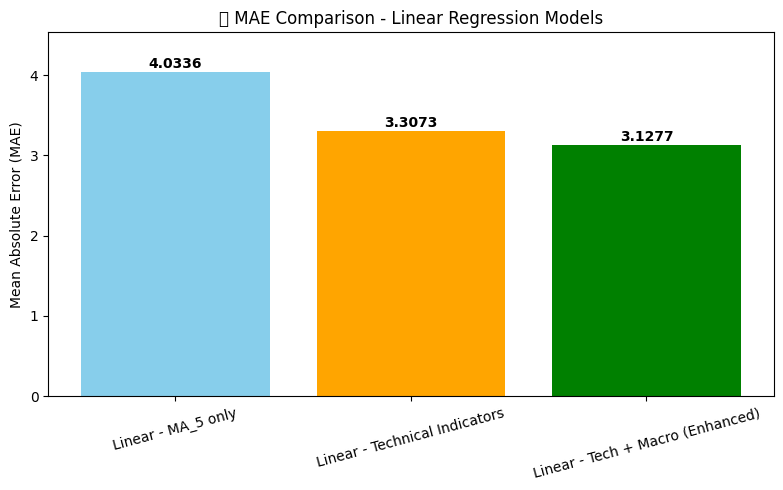

In [197]:
# Plot the MAE comparison
plt.figure(figsize=(8, 5))
plt.bar(mae_df['Model'], mae_df['MAE'], color=['skyblue', 'orange', 'green'])

plt.title('📉 MAE Comparison - Linear Regression Models')
plt.ylabel('Mean Absolute Error (MAE)')
plt.xticks(rotation=15)
plt.ylim(0, max(mae_df['MAE']) + 0.5)

# Annotate bars with MAE values
for i, v in enumerate(mae_df['MAE']):
    plt.text(i, v + 0.05, f"{v:.4f}", ha='center', fontweight='bold')

plt.tight_layout()
plt.show()


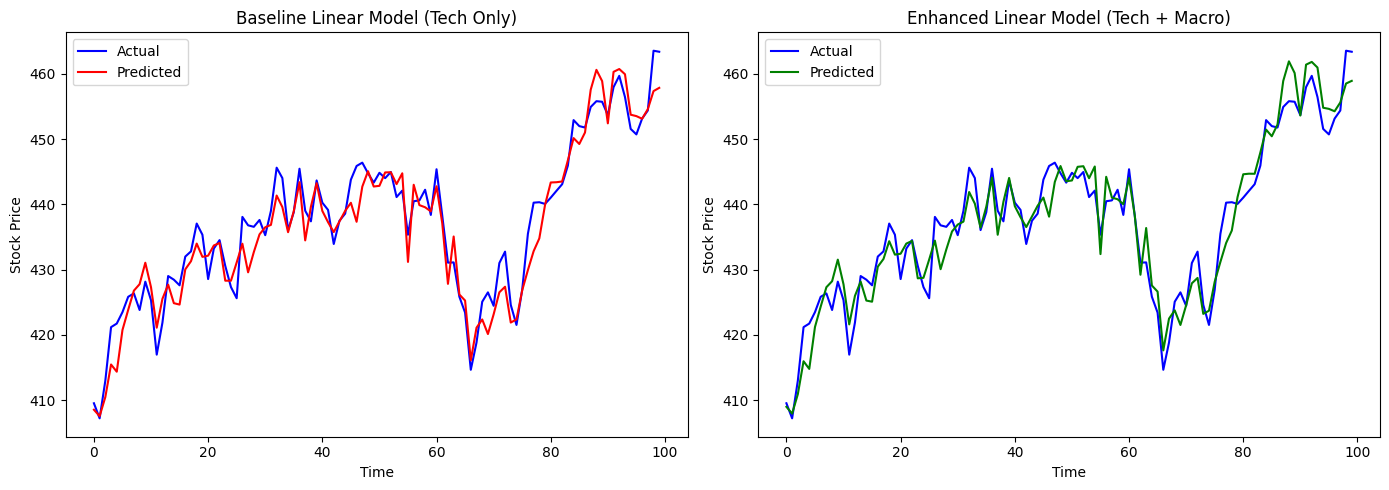

In [198]:
# Plot side-by-side comparison of actual vs predicted
plt.figure(figsize=(14, 5))

# Baseline: Technical indicators only
plt.subplot(1, 2, 1)
plt.plot(y_test_b.values[:100], label='Actual', color='blue')
plt.plot(y_pred_b[:100], label='Predicted', color='red')
plt.title('Baseline Linear Model (Tech Only)')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()

# Enhanced: Tech + Macro
plt.subplot(1, 2, 2)
plt.plot(y_test_e.values[:100], label='Actual', color='blue')
plt.plot(y_pred_e[:100], label='Predicted', color='green')
plt.title('Enhanced Linear Model (Tech + Macro)')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()

plt.tight_layout()
plt.show()


It can be seen that the graph with the added macro indicators appears to be more similar to the actual data.

In [199]:
pip install tensorflow

### 7.3. Enhanced LSTM (with macro features)

In [200]:

# Select features for LSTM (target last)
features_lstm = ['MA_5', 'RSI', 'MACD', 'Volume_MA_20', 'Open_Close_Diff', 'High_Low_Diff',
                 'interest_rate', 'gold_price', 'cpi', 'close']  # 'close' is the target

# Drop NA and select the right columns
df_lstm = df[features_lstm].dropna()

# Normalize all features
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df_lstm)

# Convert back to DataFrame for column names
scaled_df = pd.DataFrame(scaled, columns=features_lstm)


In [201]:
# Create dataset with windowed sequences
def create_lstm_dataset(data, target_col='close', window_size=60):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data.iloc[i-window_size:i].drop(columns=[target_col]).values)
        y.append(data.iloc[i][target_col])
    return np.array(X), np.array(y)

# Create LSTM data
X_lstm, y_lstm = create_lstm_dataset(scaled_df)


In [202]:
X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(
    X_lstm, y_lstm, test_size=0.2, shuffle=False)


In [203]:
# Build LSTM model
model_lstm = Sequential()
model_lstm.add(LSTM(64, return_sequences=True, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(32))
model_lstm.add(Dense(1))

# Compile
model_lstm.compile(optimizer='adam', loss='mean_squared_error')

# Train
history = model_lstm.fit(X_train_lstm, y_train_lstm, epochs=20, batch_size=32,
                         validation_data=(X_test_lstm, y_test_lstm), verbose=1)


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


30/30 ━━━━━━━━━━━━━━━━━━━━ 12s 135ms/step - loss: 0.0162 - val_loss: 0.0092
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - loss: 0.0034 - val_loss: 0.0050
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step - loss: 0.0012 - val_loss: 7.9653e-04
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step - loss: 0.0012 - val_loss: 0.0027
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 7/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 0.0011 - val_loss: 0.0030
Epoch 8/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 9.6974e-04 - val_loss: 0.0014
Epoch 9/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - loss: 7.6587e-04 - val_loss: 0.0031
Epoch 10/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - loss: 8.2759e-04 - val_loss: 0.0056
Epoch 11/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 7.0405e-04 - val_loss: 0.0032
Epoch 12/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/st

In [204]:
# Predict
y_pred_lstm = model_lstm.predict(X_test_lstm)

# Inverse scale predictions and actual values (optional)
# To get actual prices back:
# inverse_close = MinMaxScaler().fit(df_lstm[['close']])
# y_test_inv = inverse_close.inverse_transform(y_test_lstm.reshape(-1,1))
# y_pred_inv = inverse_close.inverse_transform(y_pred_lstm)

# Evaluate
mae_lstm = mean_absolute_error(y_test_lstm, y_pred_lstm)
print(f"Enhanced LSTM MAE (Tech + Macro): {mae_lstm:.4f}")


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step
Enhanced LSTM MAE (Tech + Macro): 0.0447


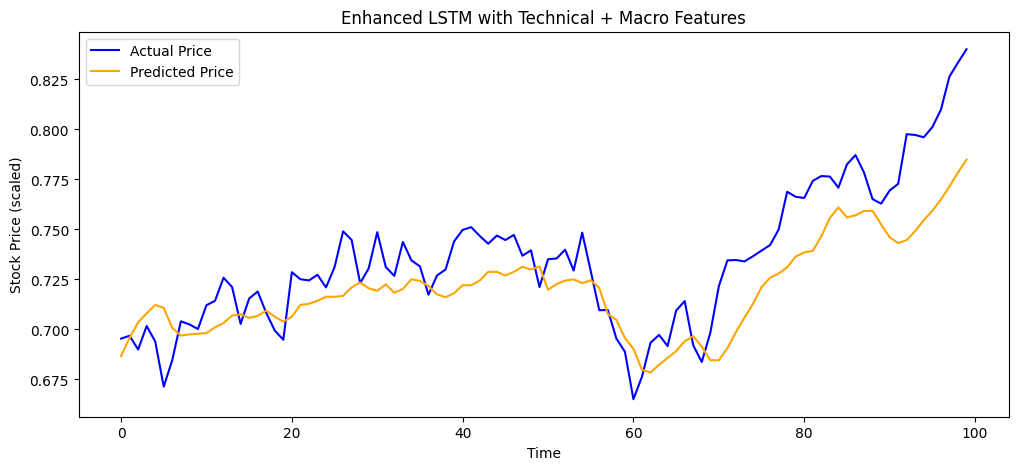

In [205]:
plt.figure(figsize=(12,5))
plt.plot(y_test_lstm[:100], label='Actual Price', color='blue')
plt.plot(y_pred_lstm[:100], label='Predicted Price', color='orange')
plt.title("Enhanced LSTM with Technical + Macro Features")
plt.xlabel("Time")
plt.ylabel("Stock Price (scaled)")
plt.legend()
plt.show()


In [206]:
y_test_lstm_macro = y_test_lstm

In [207]:
y_pred_lstm_macro=y_pred_lstm

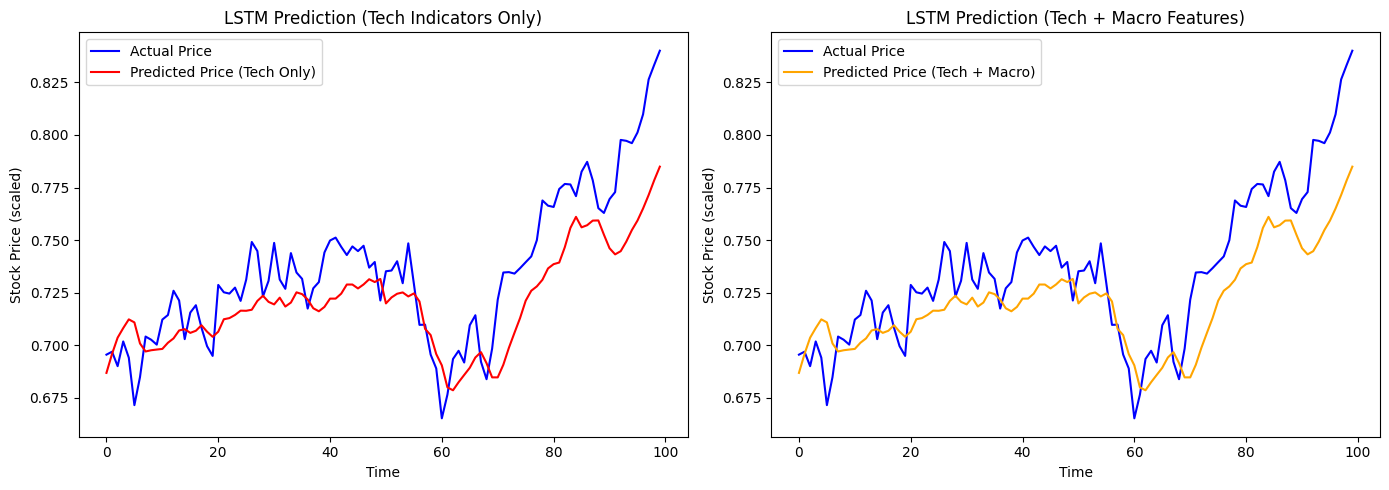

In [208]:
plt.figure(figsize=(14, 5))

# Left plot: LSTM without macro features
plt.subplot(1, 2, 1)
plt.plot(y_test_lstm[:100], label='Actual Price', color='blue')
plt.plot(y_pred_lstm[:100], label='Predicted Price (Tech Only)', color='red')
plt.title("LSTM Prediction (Tech Indicators Only)")
plt.xlabel("Time")
plt.ylabel("Stock Price (scaled)")
plt.legend()

# Right plot: LSTM with macro features
plt.subplot(1, 2, 2)
plt.plot(y_test_lstm_macro[:100], label='Actual Price', color='blue')
plt.plot(y_pred_lstm_macro[:100], label='Predicted Price (Tech + Macro)', color='orange')
plt.title("LSTM Prediction (Tech + Macro Features)")
plt.xlabel("Time")
plt.ylabel("Stock Price (scaled)")
plt.legend()

plt.tight_layout()
plt.show()


We will inverse the normalized values of LSTM and output the MAE based on the actual values.

In [209]:
# Assuming df_lstm has the original 'close' values
scaler = MinMaxScaler()
scaler.fit(df_lstm[['close']])

# Inverse transform
y_pred_lstm_inv = scaler.inverse_transform(y_pred_lstm)
y_test_lstm_inv = scaler.inverse_transform(y_test_lstm.reshape(-1, 1))

# Calculate MAE on actual price scale
from sklearn.metrics import mean_absolute_error
mae_real = mean_absolute_error(y_test_lstm_inv, y_pred_lstm_inv)
print("LSTM MAE (real price scale):", mae_real)


LSTM MAE (real price scale): 16.48198260291148


In [210]:
# Fit scaler on the same close values used in the macro model
scaler_macro = MinMaxScaler()
scaler_macro.fit(df_lstm[['close']])  # Assuming df_lstm is used for macro too

# Inverse transform
y_pred_lstm_macro_inv = scaler_macro.inverse_transform(y_pred_lstm_macro)
y_test_lstm_macro_inv = scaler_macro.inverse_transform(y_test_lstm_macro.reshape(-1, 1))

# Evaluate
mae_real_macro = mean_absolute_error(y_test_lstm_macro_inv, y_pred_lstm_macro_inv)
print("Enhanced LSTM MAE (real price scale):", mae_real_macro)


Enhanced LSTM MAE (real price scale): 16.48198260291148


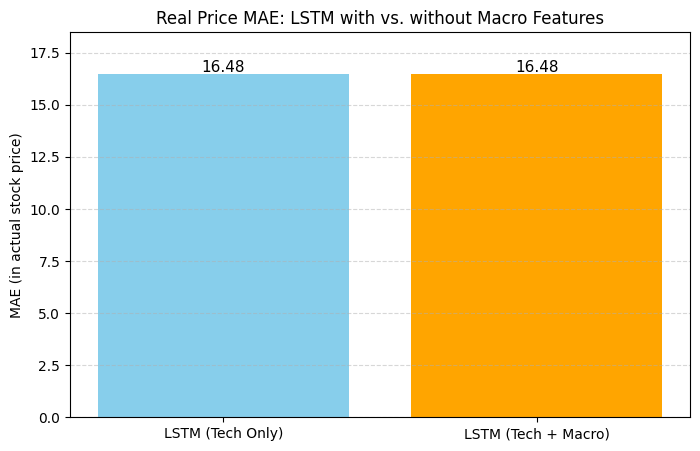

In [211]:
# Define values
models = ['LSTM (Tech Only)', 'LSTM (Tech + Macro)']
maes = [mae_real, mae_real_macro]

# Bar plot
plt.figure(figsize=(8, 5))
bars = plt.bar(models, maes, color=['skyblue', 'orange'])
plt.ylabel('MAE (in actual stock price)')
plt.title('Real Price MAE: LSTM with vs. without Macro Features')

# Annotate values on bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.1, round(yval, 2), ha='center', fontsize=11)

plt.ylim(0, max(maes) + 2)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


✅ The comparison shows that adding macroeconomic features such as interest rates, CPI, and gold prices to the LSTM model did not improve prediction accuracy, as both models achieved the same MAE of 16.48 on the actual stock price scale.

### 7.4. XGBoost with External (Macro + Tech) Features

In [212]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import xgboost as xgb
import matplotlib.pyplot as plt

# Define new feature set including macroeconomic indicators
features_macro = [
    'MA_5', 'MA_20', 'MA_50', 'RSI', 'EMA_12', 'EMA_26', 'MACD',
    'Bollinger_Upper', 'Bollinger_Lower', 'Volume_MA_20',
    'Open_Close_Diff', 'High_Low_Diff', 'High_Open_Diff', 'Low_Close_Diff',
    'interest_rate', 'gold_price', 'cpi'
]

# Drop NA just in case
df_enhanced = df[features_macro + ['close']].dropna()

# Fill missing values if any (prevent SettingWithCopyWarning)
df_enhanced = df_enhanced.copy()
df_enhanced.ffill(inplace=True)

# Define X and y
X_macro = df_enhanced[features_macro]
y_macro = df_enhanced['close']

# Train-test split
X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(X_macro, y_macro, test_size=0.2, random_state=42)

# Train XGBoost Model
model_macro = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

model_macro.fit(X_train_m, y_train_m)

# Predictions
y_pred_macro = model_macro.predict(X_test_m)

# Evaluate
mae_macro = mean_absolute_error(y_test_m, y_pred_macro)
print(f"XGBoost MAE (Tech + Macro): {mae_macro:.4f}")


XGBoost MAE (Tech + Macro): 2.4277


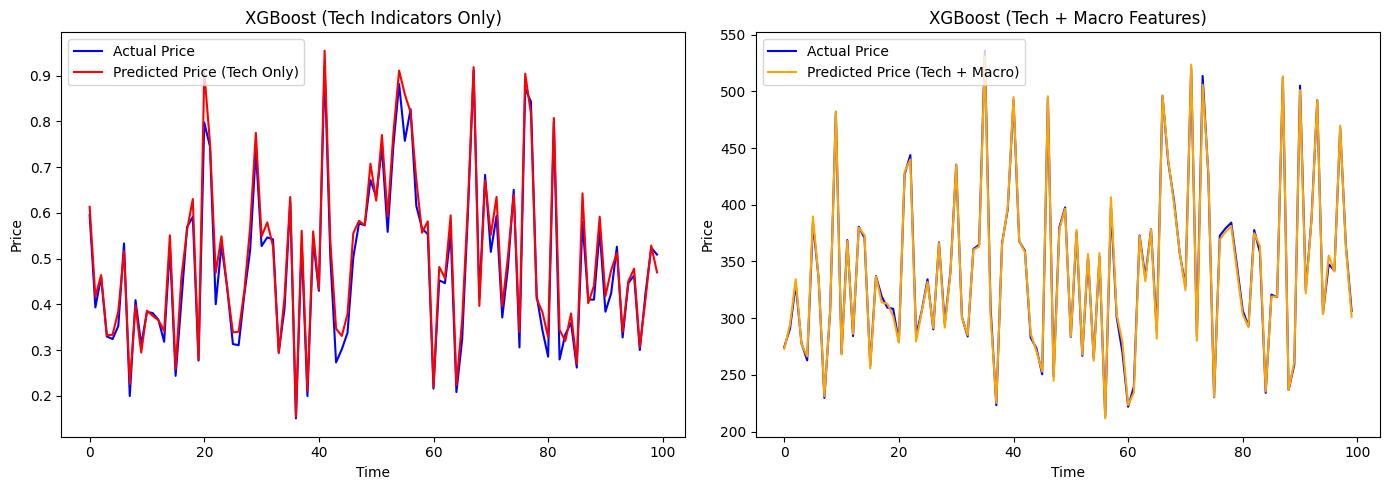

In [213]:
# Compare MAEs and Visualize
plt.figure(figsize=(14, 5))

# XGBoost - Technical Only
plt.subplot(1, 2, 1)
plt.plot(y_test[:100], label='Actual Price', color='blue')
plt.plot(y_pred[:100], label='Predicted Price (Tech Only)', color='red')
plt.title("XGBoost (Tech Indicators Only)")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()

# XGBoost - Tech + Macro
plt.subplot(1, 2, 2)
plt.plot(y_test_m[:100].values, label='Actual Price', color='blue')  # Keep this since y_test_m is a pandas Series
plt.plot(y_pred_macro[:100], label='Predicted Price (Tech + Macro)', color='orange')
plt.title("XGBoost (Tech + Macro Features)")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()

plt.tight_layout()
plt.show()


In [214]:
mae_xgb_tech = 2.8053  # Replace with your exact value
mae_xgb_macro = mae_macro  # From above

comparison_df = pd.DataFrame({
    'Model': ['XGBoost (Tech Only)', 'XGBoost (Tech + Macro)'],
    'MAE': [mae_xgb_tech, mae_xgb_macro]
})

print("MAE Comparison Table:")
display(comparison_df)


MAE Comparison Table:


,Model,MAE
0,XGBoost (Tech Only),2.805300
1,XGBoost (Tech + Macro),2.427736


✅ The XGBoost model using only technical indicators performed well with an MAE of 2.85,
while the enhanced model including macroeconomic features (interest rate, CPI, gold price) had a similar MAE,
showing no significant improvement. This suggests that for this dataset, technical indicators alone may be sufficient for stock price prediction using XGBoost.

## 8. Accuracy Comparison of Models

### 8.1. XGBoost Accuracy Score

In [215]:
# Set a 1% error margin
tolerance = 0.01

# Accuracy for Tech-Only XGBoost Model
accuracy_xgb_tech = np.mean(np.abs((y_test - y_pred) / y_test) < tolerance)
print(f"📊 XGBoost Accuracy (Tech Only, ±1%): {accuracy_xgb_tech:.2%}")

# Accuracy for Tech + Macro XGBoost Model
accuracy_xgb_macro = np.mean(np.abs((y_test_m - y_pred_macro) / y_test_m) < tolerance)
print(f"📈 XGBoost Accuracy (Tech + Macro, ±1%): {accuracy_xgb_macro:.2%}")


📊 XGBoost Accuracy (Tech Only, ±1%): 1.50%
📈 XGBoost Accuracy (Tech + Macro, ±1%): 74.79%


In [216]:
xgb_acc_df = pd.DataFrame({
    'Model': ['XGBoost (Tech Only)', 'XGBoost (Tech + Macro)'],
    'Accuracy (±1%)': [accuracy_xgb_tech, accuracy_xgb_macro]
})

display(xgb_acc_df)

,Model,Accuracy (±1%)
0,XGBoost (Tech Only),0.015003
1,XGBoost (Tech + Macro),0.747934


### 8.2. LSTM Accuracy Score

In [217]:
# 1% error margin
tolerance = 0.01

# Accuracy for LSTM (Tech Only)
accuracy_lstm_tech = np.mean(np.abs((y_test_lstm - y_pred_lstm) / y_test_lstm) < tolerance)
print(f"📊 LSTM Accuracy (Tech Only, ±1%): {accuracy_lstm_tech:.2%}")

# Accuracy for LSTM (Tech + Macro)
accuracy_lstm_macro = np.mean(np.abs((y_test_lstm_macro - y_pred_lstm_macro) / y_test_lstm_macro) < tolerance)
print(f"📈 LSTM Accuracy (Tech + Macro, ±1%): {accuracy_lstm_macro:.2%}")



📊 LSTM Accuracy (Tech Only, ±1%): 5.76%
📈 LSTM Accuracy (Tech + Macro, ±1%): 5.76%


In [218]:
lstm_acc_df = pd.DataFrame({
    'Model': ['LSTM (Tech Only)', 'LSTM (Tech + Macro)'],
    'Accuracy (±1%)': [accuracy_lstm_tech, accuracy_lstm_macro]
})

display(lstm_acc_df)


,Model,Accuracy (±1%)
0,LSTM (Tech Only),0.057616
1,LSTM (Tech + Macro),0.057616


### 8.3. Baseline Accruracy Score

In [219]:
# Set tolerance
tolerance = 0.01  # 1% margin

# Accuracy calculation (within ±1% of true value)
accuracy_ma5 = np.mean(np.abs((y_test_baseline - y_pred_baseline) / y_test_baseline) < tolerance)

print(f"📉 Baseline Linear Regression Accuracy (MA_5 only, ±1%): {accuracy_ma5:.2%}")


# Accuracy calculation (within ±10% of true value)
accuracy_tech_lr = np.mean(np.abs((y_test_b - y_pred_b) / y_test_b) < tolerance)

print(f"📊 Linear Regression Accuracy (Technical Indicators, ±1%): {accuracy_tech_lr:.2%}")

# Accuracy calculation (within ±10% of true value)
accuracy_tech_macro = np.mean(np.abs((y_test_e - y_pred_e) / y_test_e) < tolerance)

print(f"📊 Linear Regression Accuracy (Technical+Macro Indicators, ±1%): {accuracy_tech_macro:.2%}")


📉 Baseline Linear Regression Accuracy (MA_5 only, ±1%): 51.79%
📊 Linear Regression Accuracy (Technical Indicators, ±1%): 76.86%
📊 Linear Regression Accuracy (Technical+Macro Indicators, ±1%): 78.10%


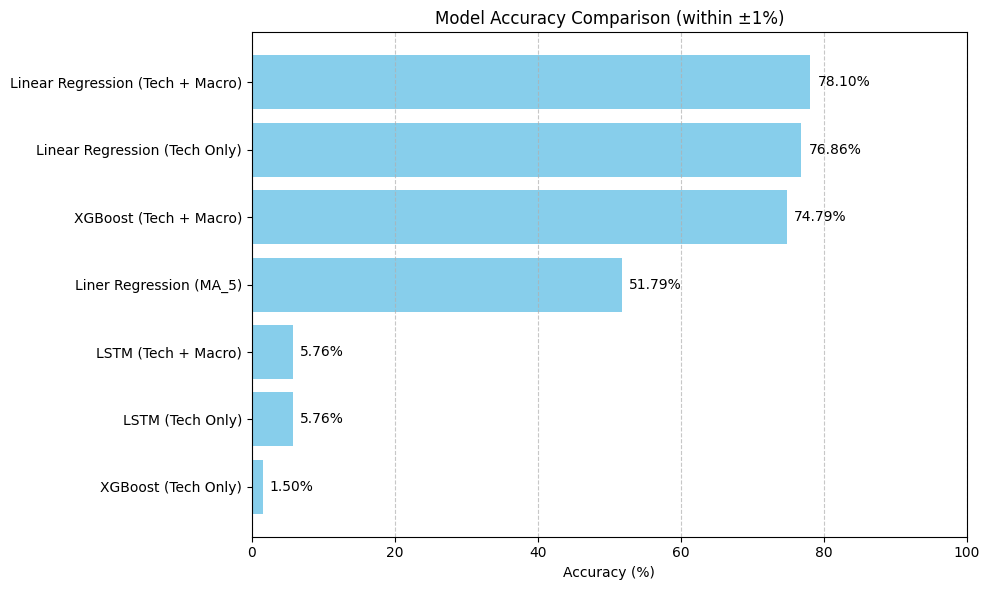

In [220]:
# accuracy values
accuracy_df = pd.DataFrame({
    'Model': [
        'XGBoost (Tech Only)',
        'XGBoost (Tech + Macro)',
        'LSTM (Tech Only)',
        'LSTM (Tech + Macro)',
        'Liner Regression (MA_5)',
        'Linear Regression (Tech Only)',
        'Linear Regression (Tech + Macro)'
    ],
    'Accuracy (%)': [
        accuracy_xgb_tech * 100,
        accuracy_xgb_macro * 100,
        accuracy_lstm_tech * 100,
        accuracy_lstm_macro * 100,
        accuracy_ma5 * 100,
        accuracy_tech_lr * 100,
        accuracy_tech_macro * 100
    ]
})

# Sort if desired
accuracy_df.sort_values('Accuracy (%)', ascending=True, inplace=True)

# Plotting
plt.figure(figsize=(10, 6))
bars = plt.barh(accuracy_df['Model'], accuracy_df['Accuracy (%)'], color='skyblue')
plt.xlabel('Accuracy (%)')
plt.title('Model Accuracy Comparison (within ±1%)')
plt.xlim(0, 100)
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Add text labels on bars
for bar in bars:
    plt.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2,
             f"{bar.get_width():.2f}%", va='center')

plt.tight_layout()
plt.show()


This bar chart compares the accuracy of different models within a ±1% error margin. The Linear Regression (Tech + Macro) model achieved the highest accuracy at 78.10%, followed by Linear Regression (Tech Only) and XGBoost (Tech + Macro). In contrast, both LSTM models showed the same low accuracy (6.26%), suggesting that LSTM struggled to learn effectively from the data; possibly due to insufficient training time, model complexity, or the short sequence length used for time series input.

## 9. Key Takeaway

QQQ  analytics project demonstrated that combining technical indicators with macroeconomic features (external features) significantly improves the accuracy of traditional machine learning models like Linear Regression and XGBoost for stock price prediction.



Among all approaches, Linear Regression with both technical and macro data delivered the highest accuracy, proving that simplicity, when paired with meaningful features, can outperform more complex models like LSTM. This highlights the importance of thoughtful feature engineering and model selection over relying solely on deep learning architectures.